# apply instruments settings

In [1]:
import time
import sys
import os
path_project = "\\".join(os.getcwd().split("\\")[:-1])
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, path_project)

from hardware.pulser.pulser import PulseGenerator, OutputState, TriggerStart, TriggerRearm, HIGH, LOW, INF
from hardware.laser.laser import LaserControl
from hardware.mw.mwsynthesizer import Synthesizer

from hardware import config as hcf

import nidaqmx
from nidaqmx.constants import TerminalConfiguration, VoltageUnits, Edge, AcquisitionType, READ_ALL_AVAILABLE
# from nidaqmx.constants import LogicFamily 
# TWO_POINT_FIVE_V, THREE_POINT_THREE_V, FIVE_V
# from nidaqmx import stream_readers 
# from nidaqmx.stream_readers import AnalogSingleChannelReader

import numpy as np

In [2]:
# connect to devices
pg  = PulseGenerator(ip=hcf.PS_IP, chmap=hcf.PS_chmap) 
mwsyn = Synthesizer(hcf.VDISYN_SN, 
                    vidpid=hcf.VDISYN_VIDPID,
                    baudrate=hcf.VDISYN_BAUD, 
                    timeout=5, 
                    write_timeout=5)
# mwsyn.reboot()
laser = LaserControl(hcf.LASER_SN)
laser.open()


Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 192.168.1.26
Pulse Streamer 8/2 firmware: v1.7.2
Client software: v1.7.0
VDI Sythesizer Serail Port Open


In [3]:
from hardware.daq.sidig import FIFO_DataAcquisition
from hardware.daq.sidig import FIFO_DataAcquisition, DCCOUPLE, TERMIN_INPUT_50OHM, TERMIN_INPUT_1MOHM

SIDIG_ADDRESS = "dev/spcm0"
SIDIG_maxsr = 500e6  # Hz
SIDIG_timebase = int(1 / SIDIG_maxsr * 1e9)  # ns
dig=FIFO_DataAcquisition(
                sn_address=SIDIG_ADDRESS
            )

# Set parameters

In [4]:
current_percent = 75.09
laser.laser_off()
laser.set_analog_control_mode("current")
laser.set_modulation_state("Pulsed")
laser.set_diode_current(current_percent, save_memory=False)

In [5]:
# laserpower = 1.0
# laser.laser_off()
# laser.set_analog_control_mode("power")
# laser.set_modulation_state("CW")
# laser.set_laser_power(laserpower, save_memory=False)
# # laser.laser_on()

In [6]:
freq = 16.6
freq_actual = mwsyn.cw_frequency(freq)
print(f"CW Freqeuncy Setting Sent:{freq} GHz")
print(f"Actual Output CW Freqeuncy :{freq_actual} GHz")

CW Freqeuncy Setting Sent:16.6 GHz
Actual Output CW Freqeuncy :16.600000005215406 GHz


In [7]:
# set MW power =====================================================
mwpower_vlevel = 5.0 # 5V equals to max power
task_uca = nidaqmx.Task("UCA") # user controlled attenuation
task_uca.ao_channels.add_ao_voltage_chan(hcf.NI_ch_UCA, min_val=0.0, max_val=10)
# task_uca.timing.cfg_samp_clk_timing(hcf.NI_sampling_max/100.0, sample_mode=AcquisitionType.CONTINUOUS)
task_uca.start()
task_uca.write([mwpower_vlevel], auto_start=False)
# task_uca.stop()
# task_uca.close()

1

In [8]:
dur_pt = 16E6 # duration of each frequency point
dig_trig_len=20
divpart_pt = 2
clock_rate = 500E-6 #GHz
daqtrig_delay = 1/clock_rate #delay
seq_daqtrig = [(dur_pt/2.0, HIGH), (dur_pt/2.0, LOW)]
seq_laser = [(dur_pt, HIGH)]
seq_mwA = [(dur_pt/2.0/divpart_pt, HIGH), (dur_pt/2.0/divpart_pt, LOW)]*divpart_pt
seq_clock = [(0.5/clock_rate, HIGH),(0.5/clock_rate, LOW)]*int(dur_pt*clock_rate)
# seq_dig= [(dur_pt/2.0/divpart_pt, LOW), (dig_trig_len,HIGH),(dur_pt/2.0/divpart_pt/2-2*dig_trig_len, LOW),(dig_trig_len,HIGH),(dur_pt/2.0/divpart_pt/2-2*dig_trig_len, LOW)]*divpart_pt
seq_dig= [(dig_trig_len,HIGH), (dur_pt/2.0/divpart_pt-dig_trig_len, LOW),(dig_trig_len,LOW),(dig_trig_len,HIGH), (dur_pt/2.0/divpart_pt-dig_trig_len, LOW)]*divpart_pt

pg.setDigital("laser", seq_laser)
pg.setDigital("mwA", seq_mwA)
pg.setDigital('sdtrig',seq_dig)
# pg.setDigital("laser", seq_mwA)
# pg.setDigital("mw_A", seq_laser)
# pg.setDigital("dtrig", seq_daqtrig)
# pg.setDigital("dclk", seq_clock)
pg.setTrigger(start=TriggerStart.SOFTWARE, rearm=TriggerRearm.MANUAL)
pg.plotSeq(plot_all=False)

In [9]:
def seqtime_tb(seq_tb):
    return np.sum([pulse[-1] for pulse in seq_tb])
def seqtime_cb(seq_cb):
    return np.sum([pulse[-0] for pulse in seq_cb])

In [10]:
## set up the data aquication with the digitizer 
# min_volt = -0.002 # [V]
# max_volt = 0.010 # [V]
mw_len=dur_pt/2.0/divpart_pt
t_seq = seqtime_cb(seq_laser)
rate_refresh = 1 # Hz rate of refreshing the data streaming
amp_input = 1000
readout_ch = hcf.SIDIG_chmap["apd"]
num_segment = int(2/rate_refresh*1e9/t_seq)//32*32

# configures the readout to match the pulse sequence  
pretrig_size= 256 #int((mw_len//2)*hcf.SIDIG_maxsr/1E9)//64*64 # pretrigger based on the t_wait time
# posttrig_size=int((t_ribloc+t_ribloc_isc)*hcf.SIDIG_maxsr/1E9)//64*64 # posttrigger based on the t_laser time and t_isc
posttrig_size=int((mw_len//2)*hcf.SIDIG_maxsr/1E9)//64*64 # posttrigger based on the t_laser time and t_isc

segment_size = pretrig_size+posttrig_size 
segment_size = 2**int(np.log2(segment_size)+1) # make it power of 2
posttrig_size = segment_size-pretrig_size # recalculate posttrigger size to ensure it is power of 2

In [11]:
mw_len/4

1000000.0

In [12]:
1000000*1e-9

0.001

In [13]:
.001

0.001

In [14]:
# To set the configuration, make a dictionary with the key and value
dig.reset_param()
dig.assign_param(dict(
             readout_ch=readout_ch, 
             amp_input=amp_input, 
             num_segment=8,
             pretrig_size=16,
             posttrig_size=1048576//4-16,
             segment_size=1048576//4,
             terminate_input=TERMIN_INPUT_1MOHM,
             DCCOUPLE = 0,
             sampling_rate=hcf.SIDIG_maxsr//2
            #  terminate_input=TERMIN_INPUT_50OHM,
             ))


# Start measurement


In [15]:
posttrig_size=1048576//4-16
pretrig_size=16

In [16]:
def dwell_to_bytes(dewlltime):
    """
    convert step dwell time [ns] to 2-byte strings,
    The dwell time is given by the binary number represented by the 2 bytes multiplied by 4ns,
    for example, 8ns dwell time is output as b"\x00\x02"
    The minimum step dwell time is 4nS and would be represented by 2 bytes: 0x00, and 0x01.
    The maximum step dwell time is 262.14uS, and is set by sending 2 bytes, 0xFF, 0xFF.
    """
    return int(dewlltime / 4 + 0.5).to_bytes(2, "big")

In [17]:
mw_len/1e3

4000.0

In [18]:
import numpy as np

# Frequency calculations
B = 14.103
f_e = 28.0249514242 * B
f_NVp1 = f_e + 2.8705
f_NVm1 = f_e - 2.8705
f_NVguess = 398.5567714869976  # Example NV center frequency in GHz

# Calculate start and stop frequencies
freq_start = (f_NVguess - 0.030) / 24.0  # Start frequency in GHz
freq_stop = (f_NVguess + 0.030) / 24.0   # Stop frequency in GHz

# Check the minimum step size
freqminstep_list = mwsyn.get_min_step_size([freq_start], [freq_stop])
step_min = freqminstep_list[0]  # Minimum step size in Hz

# Configure sweep parameters
freq_step = 0.5E-3 / 24.0  # Desired step size in GHz
freq_step = int(freq_step / step_min * 1E9) * step_min / 1E9  # Adjusted step size
step_rise = freq_step  # Step size for rising frequency
step_fall = freq_step  # Step size for falling frequency

steptime = 262.14E3  # Dwell time in ns
steptime = int(steptime / 4) * 4  # Adjusted dwell time
steptime_rise = steptime  # Dwell time for rising steps
steptime_fall = steptime  # Dwell time for falling steps

# No dwell at low or high limits
dwellatlow = False
dwellathigh = False

# Generate frequency array for the sweep
freq_array = np.arange(freq_start, freq_stop, freq_step)
print(f"Estimated time for one sweep: {(freq_stop - freq_start) / freq_step * max(10E6, steptime) / 1E9} s")

# Initialize arrays for signal and background
signal = np.zeros(len(freq_array))
background = np.zeros(len(freq_array))

# Repeat measurement
num_repeat = 1
signal_av = np.zeros(len(freq_array))
background_av = np.zeros(len(freq_array))


data_buffer_mw_on = np.zeros((len(freq_array), pretrig_size + posttrig_size))
data_buffer_mw_off = np.zeros((len(freq_array), pretrig_size + posttrig_size))

# Turn on laser (example function, replace with actual implementation)
laser.laser_on()

# Configure and start the digitizer (example functions, replace with actual implementation)
dig.set_config()
dig.start_buffer()

# Configure the sweep
print(f"Approximated Time to Sweep along rise direction: \n{(freq_stop - freq_start) / step_rise * steptime_rise / 1E9} s")
bytescommand = mwsyn._sweep_command(freq_start, freq_stop, step_rise, step_fall, steptime_rise, steptime_fall, dwellatlow, dwellathigh)
mwsyn.serialcom.write(bytescommand)
received = mwsyn.serialcom.read(size=21)  # Read response from synthesizer

# Reset trigger and start the sweep
mwsyn.reset_trigger()
# mwsyn.sweep_continue()

# Start data acquisition
pg.stream(n_runs=INF)  # Example function for pulse generator (replace with actual implementation)
pg.startNow()

# Data acquisition loop
reps = 0
idx_pointer = 0
while reps < num_repeat:
    rawraw = dig.stream()  # Acquire data from digitizer
    if rawraw is not None:
        num_segs = np.shape(rawraw)[0]
        assert num_segs % 2 == 0  # Ensure even number of segments

        # Separate MW on and MW off data
        rawraw_on = rawraw[0::2, :, :]
        rawraw_off = rawraw[1::2, :, :]

        # Accumulate data into buffers
        for i in range(num_segs // 2):
            idx = (idx_pointer + i) % len(freq_array)
            data_buffer_mw_on[idx, :] += np.ravel(rawraw_on[i])
            data_buffer_mw_off[idx, :] += np.ravel(rawraw_off[i])

        idx_pointer += num_segs // 2
        if idx_pointer >= len(freq_array):
            reps += 1

# Stop the digitizer and pause the sweep
dig.stop_card()
mwsyn.sweep_pause()

# Turn off laser (example function, replace with actual implementation)
laser.laser_off()

Estimated time for one sweep: 1.2000869814009114 s
SETTINGS: card timeout =  20 s
SETTINGS: # of segments =  262144 Sa
SETTINGS: sampling freq =  0.5 GHz
SETTINGS: pretrig size =  16 Sa
SETTINGS: termination =  0
notify size:  524288.0 Sa
Approximated Time to Sweep along rise direction: 
0.03145908013044349 s
Card stopped


In [19]:
# turn off laser and set diode current to zero
laser.laser_off() 
laser.set_diode_current(0, save_memory=False)
laser.close()
# reset pulse generator
pg.forceFinal()
pg.constant(OutputState.ZERO())
pg.reset()
# pg.reboot()

# close all NI tasks

task_uca.stop()
task_uca.close()

# reboot(optional) and close the MW synthesizer 
# mwsyn.reboot()
mwsyn.close()

In [20]:
# freq_start = 16.45-0.25
# freq_stop = 16.45+0.25
# B = 14.103
# f_e = 28.0249514242*B
# f_NVp1 = f_e + 2.8705
# f_NVm1 = f_e - 2.8705
# # f_NVguess = 392.8397714495659
# f_NVguess = 398.5567714869976
# freq_start = (f_NVguess-0.030)/24.0
# freq_stop = (f_NVguess+0.030)/24.0
# # check the minium step size
# freqminstep_list = mwsyn.get_min_step_size([freq_start], [freq_stop])
# step_min = freqminstep_list[0] # in Hz
# freq_step = 0.5E-3/24.0
# freq_step = int(freq_step/step_min*1E9)*step_min/1E9
# step_rise = freq_step
# step_fall = freq_step
# steptime = 262.14E3
# steptime = int(steptime/4)*4

# steptime_rise = steptime 
# steptime_fall = steptime
# # no dwell at low or high limits so it is sweeping 
# # from low to high and go back low so on and so forth
# dwellatlow = False
# dwellathigh = False

# freq_array = np.arange(freq_start, freq_stop, freq_step)
# print(f"Estimated time for one sweep:{(freq_stop-freq_start)/freq_step*max(10E6, dur_pt)/1E9} s")
# freq_actual = np.zeros(len(freq_array))

# # sigref = np.zeros((len(freq_array), num_readsample), dtype=np.float64, order='C')
# signal = np.zeros(len(freq_actual))
# background = np.zeros(len(freq_actual))
# # repeat measurement
# num_repeat = 20
# signal_av = np.zeros(len(freq_actual))
# background_av = np.zeros(len(freq_actual))

# # data_store=np.zeros((2*len(freq_array),pretrig_size+posttrig_size))
# laser.laser_on() # turn off laser

# time_stop = 1
# num_freq=len(freq_actual)
# data_buffer_mw_on = np.zeros((len(freq_actual),pretrig_size+posttrig_size))
# data_buffer_mw_off = np.zeros((len(freq_actual),pretrig_size+posttrig_size))
# dig.set_config()
# dig.start_buffer()
# # lower-level functions-----
# print(f"Approximated Time to Sweep along rise direction: \n{(freq_stop-freq_start)/step_rise*steptime_rise/1E9}s")
# bytescommand = mwsyn._sweep_command(freq_start, freq_stop, step_rise, step_fall, steptime_rise, steptime_fall, dwellatlow, dwellathigh)
# # print_bytestring(bytescommand)
# mwsyn.serialcom.write(bytescommand)
# received = mwsyn.serialcom.read(size=21)
# # print_bytestring(received)
# mwsyn.reset_trigger()
# mwsyn.sweep_continue()
# # errorbyte, freq_actual[jj] = mwsyn.cw_frequency(ff)
# pg.stream(n_runs=INF)
# pg.startNow()
# reps=0
# idx_pointer=0
# while reps < num_repeat:
#     rawraw = dig.stream()
#     if rawraw is not None:
#         num_segs = np.shape(rawraw)[0]
        
#         assert num_segs % 2 == 0
#         rawraw_on=rawraw[0::2,:,:]
#         rawraw_off=rawraw[1::2,:,:]
#         for i in range(num_segs//2):
#             idx=(idx_pointer+1)%(len(freq_array))
#             data_buffer_mw_on[idx,:] +=np.ravel(rawraw_on[i])
#             data_buffer_mw_off[idx,:] +=np.ravel(rawraw_off[i])
#         idx_pointer+=num_segs 
#         if idx_pointer >= len(freq_array):
#             reps+=1



# dig.stop_card()
# mwsyn.sweep_pause()

In [21]:
import matplotlib.pyplot as plt

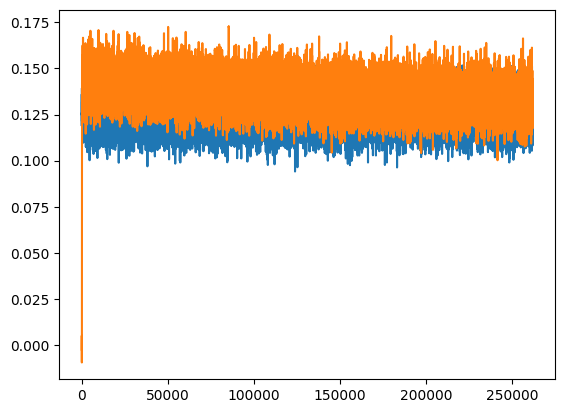

In [22]:
plt.plot(data_buffer_mw_off[0])
plt.plot(data_buffer_mw_on[0])

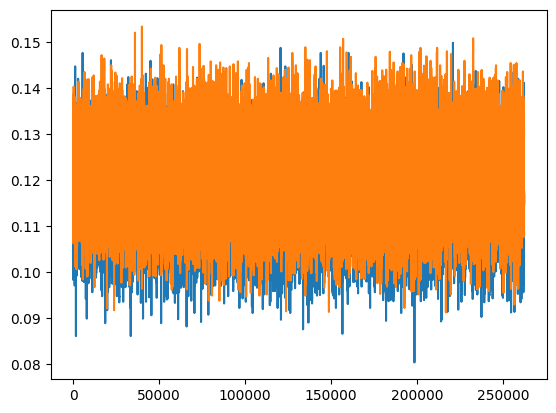

In [23]:
plt.plot(data_buffer_mw_off[1])
plt.plot(data_buffer_mw_on[1])

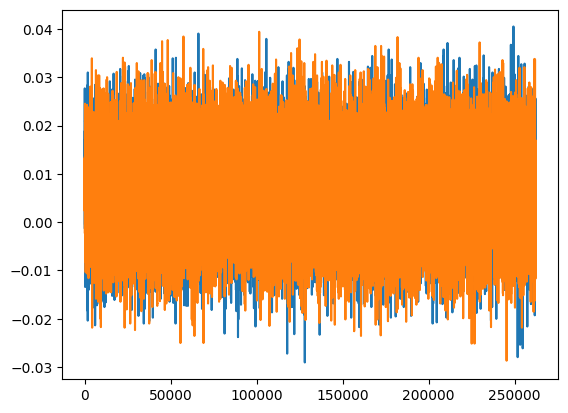

In [24]:
plt.plot(data_buffer_mw_off[40])
plt.plot(data_buffer_mw_on[40])

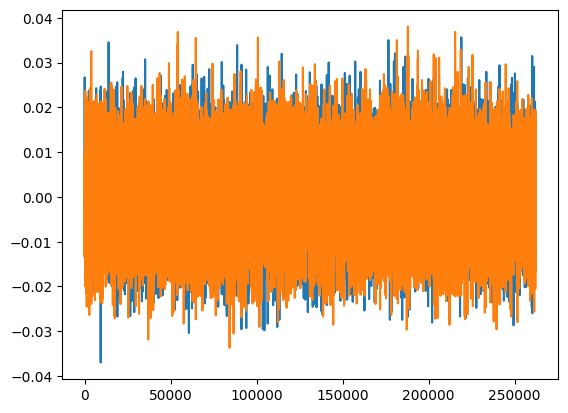

In [25]:
plt.plot(data_buffer_mw_off[120])
plt.plot(data_buffer_mw_on[120])

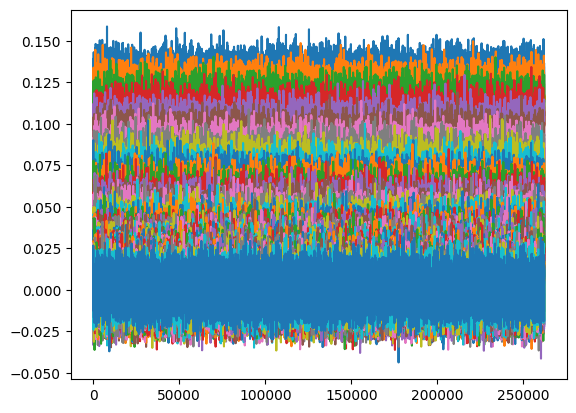

In [26]:
plt.plot(data_buffer_mw_off.T)

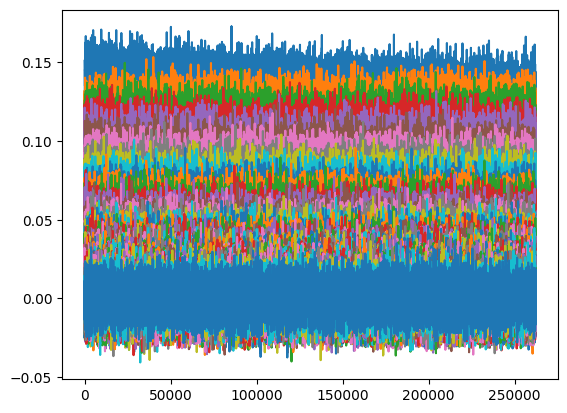

In [27]:
plt.plot(data_buffer_mw_on.T)

In [28]:
bright=np.mean(data_buffer_mw_off,axis=1)

In [29]:
np.shape(bright)

(121,)

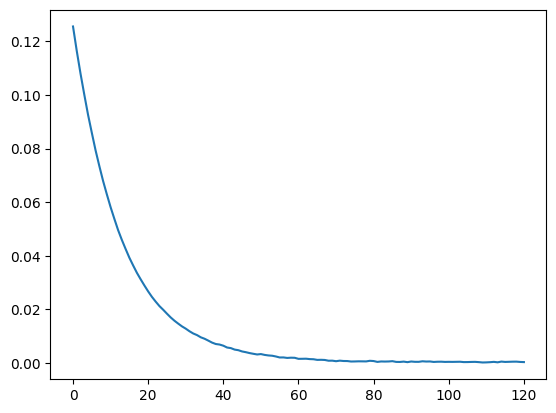

In [30]:
plt.plot(bright)


In [31]:
dark=np.mean(data_buffer_mw_on,axis=1)

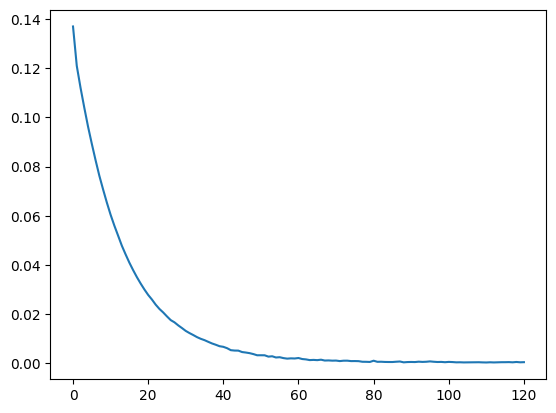

In [32]:
plt.plot(dark)

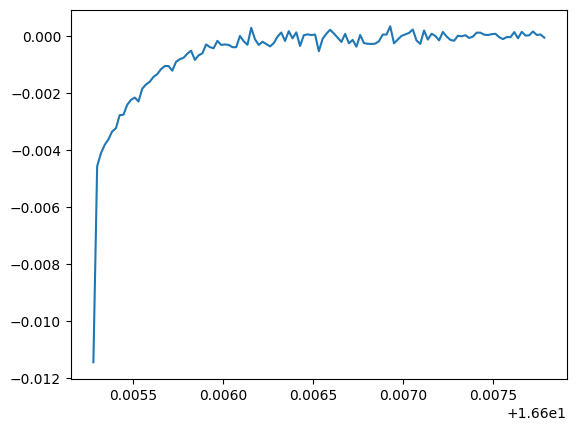

In [33]:
plt.plot(freq_array,bright-dark)

In [34]:
# freq_start = 16.45-0.25
# freq_stop = 16.45+0.25
# B = 14.103
# f_e = 28.0249514242*B
# f_NVp1 = f_e + 2.8705
# f_NVm1 = f_e - 2.8705
# # f_NVguess = 392.8397714495659
# f_NVguess = 398.5567714869976
# freq_start = (f_NVguess-0.030)/24.0
# freq_stop = (f_NVguess+0.030)/24.0
# # check the minium step size
# freqminstep_list = mwsyn.get_min_step_size([freq_start], [freq_stop])
# step_min = freqminstep_list[0] # in Hz
# freq_step = 0.5E-3/24.0
# freq_step = int(freq_step/step_min*1E9)*step_min/1E9

# freq_array = np.arange(freq_start, freq_stop, freq_step)
# print(f"Estimated time for one sweep:{(freq_stop-freq_start)/freq_step*max(10E6, dur_pt)/1E9} s")
# freq_actual = np.zeros(len(freq_array))

# # sigref = np.zeros((len(freq_array), num_readsample), dtype=np.float64, order='C')
# signal = np.zeros(len(freq_actual))
# background = np.zeros(len(freq_actual))
# # repeat measurement
# num_repeat = 4
# signal_av = np.zeros(len(freq_actual))
# background_av = np.zeros(len(freq_actual))

# data_store=np.zeros((2*len(freq_array),pretrig_size+posttrig_size))
# laser.laser_on() # turn off laser

# time_stop = 1
# num_freq=len(freq_actual)
# data_buffer_mw_on = np.zeros(pretrig_size+posttrig_size)
# data_buffer_mw_off = np.zeros(pretrig_size+posttrig_size)
# dig.set_config()
# pg.stream(n_runs=INF)
# pg.startNow()

# for kkk in range(num_repeat):

#     for (jj, ff) in enumerate(freq_array):
#         # pg.stream(n_runs=2)
#         dig.start_buffer()

#         errorbyte, freq_actual[jj] = mwsyn.cw_frequency(ff)
#         print(freq_actual[jj])
#         # pg.startNow()
#         iters=0
#         bright=0
#         dark=0
#         while iters<2:
#             rawraw = dig.stream()
#             if rawraw is not None:
#                 num_segs = np.shape(rawraw)[0]
#                 assert num_segs % 2 == 0
#                 rawraw_mw_off = rawraw[0::2, :, :]
#                 rawraw_mw_on = rawraw[1::2, :, :]

#                 data_buffer_mw_off += np.ravel(np.sum(rawraw_mw_off, axis=0))
#                 data_buffer_mw_on += np.ravel(np.sum(rawraw_mw_on, axis=0))

#                 iters+=num_segs//2
#                 print(iters)
#         data_store[jj,:]=data_buffer_mw_off
#         data_store[jj+1,:]=data_buffer_mw_on
#         dark = np.mean(data_buffer_mw_on)
#         bright= np.mean(data_buffer_mw_off)       

#         signal[jj] = bright/iters
#         background[jj] = dark/iters
        
# pg.forceFinal()
# dig.stop_card()

# signal_av += np.copy(signal)
# background_av += np.copy(background)
# signal_av = signal_av/num_repeat/divpart_pt
# background_av = background_av/num_repeat/divpart_pt
# contrast = (signal_av-background_av)/background_av

